In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import nibabel as nib
import ipywidgets as widgets

In [13]:
# --- inputs ---
#base = "2Dresults/shortpulse/"
base = "2Dresults/continuouspulse/"
#datasets = ["planar0p2mmonepulse", "planar0p5mmonepulse", "focused0p2mmonepulse", "focused0p5mmonepulse"]
datasets = ["planar0p2mmcontinuous", "planar0p5mmcontinuous", "focused0p2mmcontinuous", "focused0p5mmcontinuous"]


methodtype = ["Mesh","Linear","NN"]
grids = ["0p2mm", "0p5mm"]
time_axis = ["_t25", "_t50", "_t75", "_t100"]
SLICE_INDEX_LIST  = [i for i in range(86,121)]

ROI = np.load("ROIs/erode_C4ROI3D.npy")

# --- compute MSE values for each dataset + method ---
L2 = {d: {m: [] for m in methodtype} for d in datasets}
L1 = {d: {m: [] for m in methodtype} for d in datasets}
peak_diff = {d: {m: [] for m in methodtype} for d in datasets}
focal_dist = {d: {m: [] for m in methodtype} for d in datasets}



for ds in datasets:
    print(ds)
    for s in SLICE_INDEX_LIST:
        gtfile = base + "GroundTruth"  + "_slice" + str(s) + ds +"_Steadywave.npy"
        GT = np.load(gtfile)
        R = np.where(ROI[:, :, s], GT, 0)
        idx = np.argmax(R)
        px, py= np.unravel_index(idx, R.shape)

        for m in methodtype:
            
            simfile = base + m + "_slice" + str(s) + ds + "_Steadywave.npy"
            thissimulation = np.load(simfile)
            l2 = np.sum((GT - thissimulation) ** 2)/np.sum(GT ** 2)
            L2[ds][m].append(l2 * 100)
            
            l1 = np.max(np.abs(np.abs(GT) - np.abs(thissimulation)))/np.max(np.abs(GT))
            L1[ds][m].append(l1 * 100)
    
            focal = np.abs(np.max(np.abs(GT)) - np.max(np.abs(thissimulation))/np.max(GT))
            peak_diff[ds][m].append(focal)
            
            R = np.where(ROI[:, :, s], thissimulation, 0)
            idx = np.argmax(R)
            pxx, pyy = np.unravel_index(idx, R.shape)
            dist = np.sqrt((px - pxx)**2 + (py - pyy)**2)
            focal_dist[ds][m].append(dist)


planar0p2mmcontinuous
planar0p5mmcontinuous
focused0p2mmcontinuous
focused0p5mmcontinuous


In [ ]:
# --- inputs ---
methodtype = ["Mesh","Linear","NN"]
base = "3Dresults"
#datasets = ["0p2mm_focused_onepulse", "0p2mm_planar_onepulse", "0p5mm_focused_onepulse", "0p5mm_planar_onepulse"]
datasets = ["0p2mm_focused_continuous", "0p2mm_planar_continuous", "0p5mm_focused_continuous", "0p5mm_planar_continuous"]

# --- compute MSE values for each dataset + method ---
L2 = {d: {m: [] for m in methodtype} for d in datasets}
L1 = {d: {m: [] for m in methodtype} for d in datasets}
peak_diff = {d: {m: [] for m in methodtype} for d in datasets}
focal_dist = {d: {m: [] for m in methodtype} for d in datasets}

ROI = np.load("ROIs/erode_C4ROI3D.npy")

for ds in datasets:
    gtfile = "3Dresults/3Dsimulation_GroundTruth_"+ds +".npy"
    GT = np.load(gtfile)
    R = np.full(ROI.shape, 0, dtype=float)
    R[ROI>0] = GT
    idx = np.argmax(R)
    px, py, pz = np.unravel_index(idx, R.shape)
    for m in methodtype:
        simfile = base + "/3Dsimulation_" + m + "_" + ds + ".npy"
        thissimulation = np.load(simfile)
        l2 = np.sum((GT - thissimulation) ** 2)/np.sum(GT ** 2)
        L2[ds][m].append(l2*100)
        
        l1 = np.max(np.abs(np.abs(GT) - np.abs(thissimulation)))/np.max(np.abs(GT))
        L1[ds][m].append(l1*100)

        focal = np.abs(np.max(np.abs(GT)) - np.max(np.abs(thissimulation))/np.max(GT))
        peak_diff[ds][m].append(focal)
        
        R = np.full(ROI.shape, 0, dtype=float)
        R[ROI>0] = thissimulation
        idx = np.argmax(R)
        pxx, pyy, pzz = np.unravel_index(idx, R.shape)
        dist = np.sqrt((px - pxx)**2 + (py - pyy)**2 +(pz - pzz)**2)
        focal_dist[ds][m].append(dist/10)

In [ ]:
# --- aggregate stats ---# --- aggregate stats ---
subset = ["planar0p2mmonepulse","focused0p2mmonepulse", "planar0p5mmonepulse","focused0p5mmonepulse"]
#subset = ["planar0p2mmcontinuous", "focused0p2mmcontinuous", "planar0p5mmcontinuous", "focused0p5mmcontinuous"]

means = {d: [np.mean(peak_diff[d][m]) for m in methodtype] for d in subset}
stds  = {d: [np.std(peak_diff[d][m], ddof=1) for m in methodtype] for d in subset}

# --- plotting grouped bar chart ---
x = np.arange(len(methodtype))
width = 0.15  # bar width

fig, ax = plt.subplots()
subsetnames = ["planar source with scale of 2", "focused source with scale of 2", "planar source with scale of 5", "focused source with scale of 5"]
# shift bars left/right for grouping
for i, (dname) in enumerate(subset):
    offset = (i - 0.5) * width
    ax.bar(
        x + offset,
        means[dname],
        width,
        yerr=stds[dname],
        capsize=6,
        label=dname,
        #color=colors,
        alpha=0.8,
    )
    
ax.set_xticks(x)
ax.set_xticklabels(methodtype)
ax.set_ylabel("Linf norm (%)")
ax.set_title("Linf Norm of Steady-State Amplitude")
#ax.set_title("L1 Norm of Peak-Pressure")

#ax.set_ylim(0, 8)
#ax.set_ylim(0, 130)

ax.set_axisbelow(True)
ax.grid(axis="y", linestyle="--", alpha=0.4, zorder=0)


plt.legend(subsetnames, loc='upper left')  # choose corner
plt.tight_layout()
#plt.savefig("continuous pulse steadywave amplitude Linf batchart.svg")
#plt.savefig("short pulse peakpressure Linf batchart.svg")
plt.show()



In [61]:
cfls = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
peakpressure = []
L2 = []

c0p05 = np.load(r"2DConvergence/GroundTruth_slice0.05focused0p5mmonepulse_PeakPressure.npy")
for c in cfls:
    pp = np.load(r"2DConvergence/GroundTruth_slice"+str(c)+"focused0p5mmonepulse_PeakPressure.npy")
    peakpressure.append(np.sum(pp)/np.sum(c0p05))
    #c0p05 = peakpressure[0]
    L2.append(np.sum((c0p05 - pp) ** 2)/np.sum(c0p05 ** 2)*100)
    print(np.sum(pp))

154545.33
153479.4
153282.39
153214.89
153319.36
153398.84


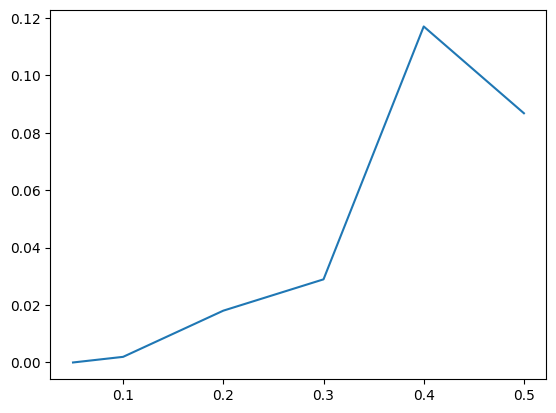

In [64]:
plt.plot(cfls,L2)